In [14]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

from inspect import trace
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm.auto import tqdm
import datetime

import warnings
warnings.filterwarnings('ignore')

In [19]:
data = pdr.get_data_yahoo(('AAPL','QQQ'))['Adj Close']
data

[*********************100%***********************]  2 of 2 completed


,AAPL,QQQ
Date,,
1980-12-12,0.099722,NaN
1980-12-15,0.094519,NaN
1980-12-16,0.087582,NaN
1980-12-17,0.089749,NaN
1980-12-18,0.092351,NaN
...,...,...
2023-03-27,158.279999,308.760010
2023-03-28,157.649994,307.119995
2023-03-29,160.770004,312.720001


In [7]:
data.loc[:'2019-3']

,Adj Close,log_ret
Date,,
2010-06-30,1.588667,-0.002515
2010-07-01,1.464000,-0.081723
2010-07-02,1.280000,-0.134312
2010-07-06,1.074000,-0.175470
2010-07-07,1.053333,-0.019431
...,...,...
2019-03-25,17.361334,-0.015659
2019-03-26,17.851334,0.027833
2019-03-27,18.322001,0.026024


In [59]:
data['rolling_std'] = 0
data['value'] = 0
data

,Adj Close,log_ret,rolling_std,value
Date,,,,
1980-12-15,0.094519,-0.053581,0,0
1980-12-16,0.087582,-0.076231,0,0
1980-12-17,0.089749,0.024450,0,0
1980-12-18,0.092351,0.028580,0,0
1980-12-19,0.097987,0.059239,0,0
...,...,...,...,...
2023-03-23,158.929993,0.006945,0,0
2023-03-24,160.250000,0.008271,0,0
2023-03-27,158.279999,-0.012369,0,0


In [52]:
for i in range(1500, len(data) - 1):
    
    historical = data.iloc[:i, :]
    historical_std = historical['log_ret'].std()
    historical_mean = historical['log_ret'].mean()
    today_value = data['Adj Close'].iloc[i]
    
    data['above_pct'].iloc[i] = historical[historical['Adj Close'] > today_value].shape[0] / historical.shape[0]
    data['below_pct'].iloc[i] = historical[historical['Adj Close'] < today_value].shape[0] / historical.shape[0]
    
    tmr_log_return = data['log_ret'].iloc[i + 1]
    if tmr_log_return > historical_mean + 2 * historical_std:
        data['value'].iloc[i] = 1
    elif tmr_log_return < historical_mean - 2 * historical_std:
        data['value'].iloc[i] = -1

In [53]:
data.value.value_counts()

 0    10390
 1      139
-1      133
Name: value, dtype: int64

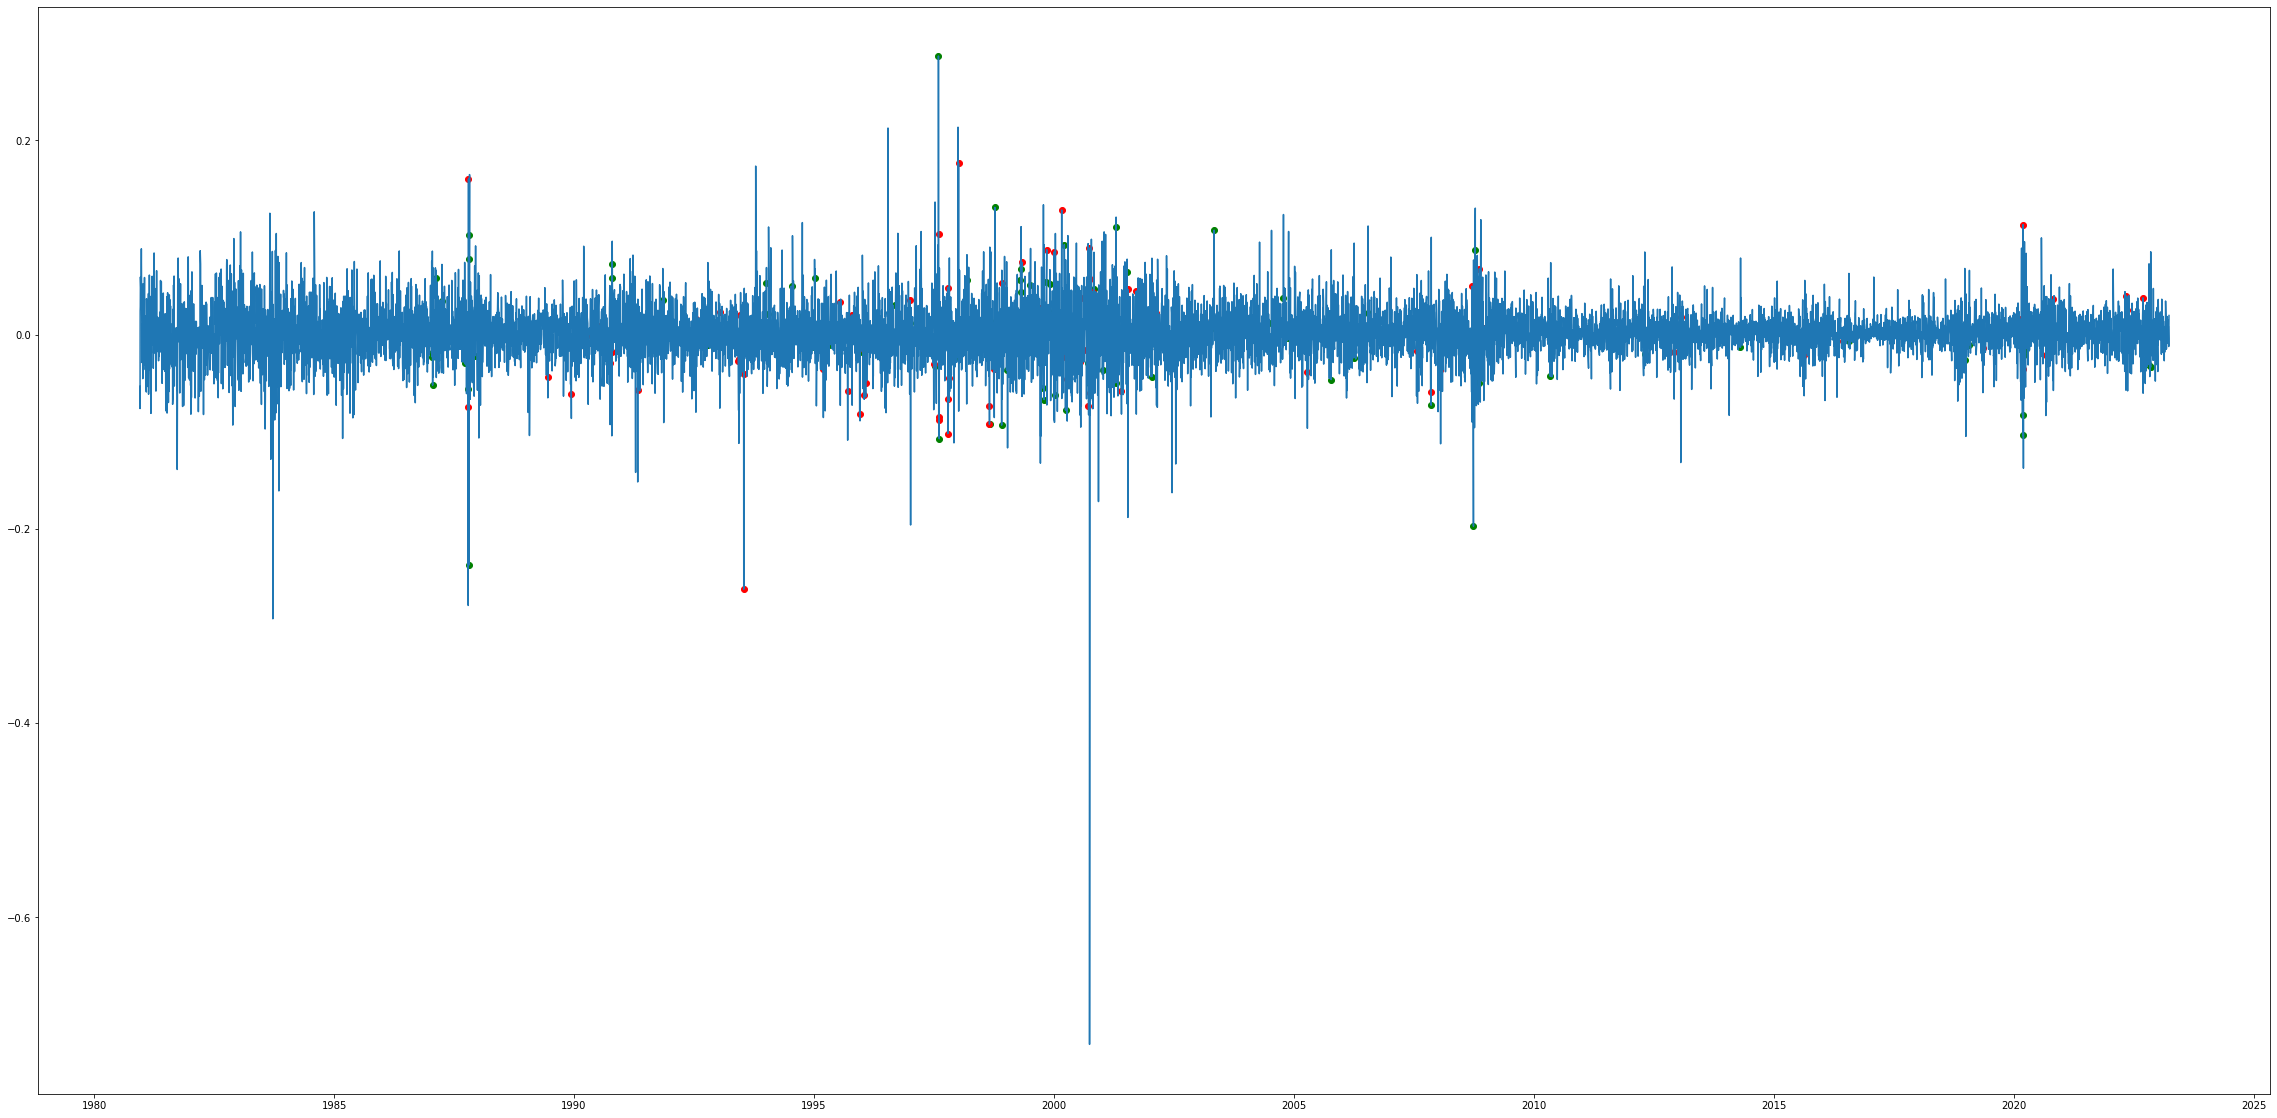

In [54]:
# mark those points on the line chart with different color
plt.figure(figsize=(40, 20))
plt.plot(data['log_ret'])

plt.scatter(data[data['value'] == 1].index, data.loc[data[data['value'] == 1].index, 'log_ret'], color='g')
plt.scatter(data[data['value'] == -1].index, data.loc[data[data['value'] == -1].index, 'log_ret'], color='r')

Text(0.5, 1.0, 'Distribution of below_pct for value of 1 and 0')

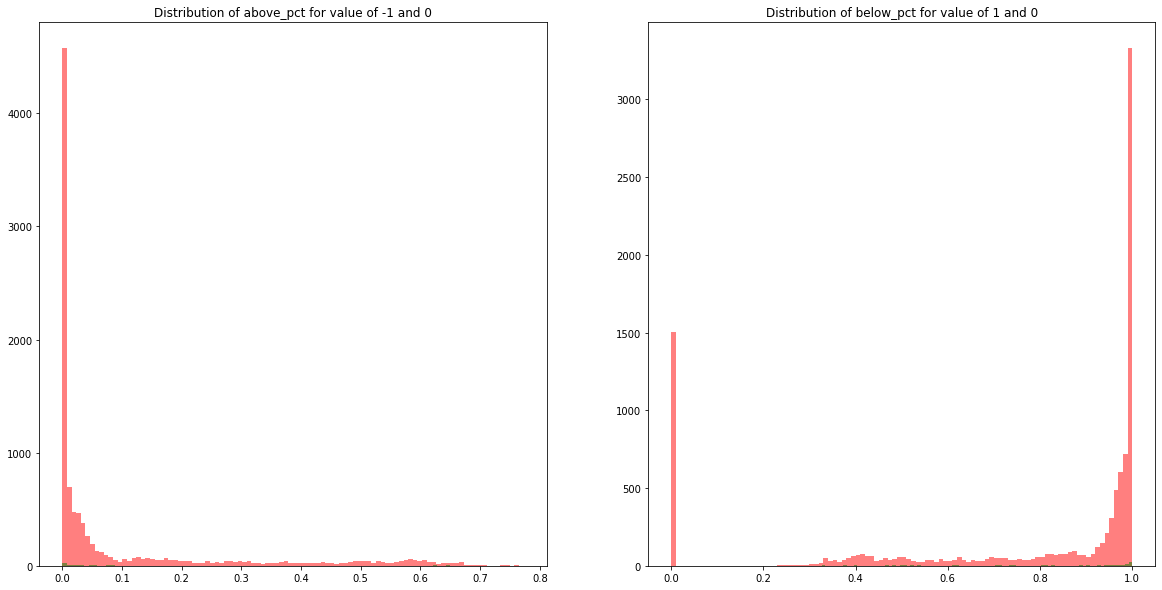

In [55]:
# plot the distribution of above_pct and below_pct for value of 1 and -1, two histagram and each graph has two classes

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(data[data['value'] == 0]['above_pct'], bins=100, color='r', alpha=0.5)
ax[0].hist(data[data['value'] == -1]['above_pct'], bins=100, color='g', alpha=0.5)
ax[0].set_title('Distribution of above_pct for value of -1 and 0')
ax[1].hist(data[data['value'] == 0]['below_pct'], bins=100, color='r', alpha=0.5)
ax[1].hist(data[data['value'] == 1]['below_pct'], bins=100, color='g', alpha=0.5)
ax[1].set_title('Distribution of below_pct for value of 1 and 0')
